<a href="https://colab.research.google.com/github/tnotstar/machine-learning-zoomcamp/blob/master/cohorts/2025/04-evaluation/submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Zoomcamp (Cohort 2025) #

## Chapter 04. Evaluation of Machine Learning for Classification ##

### Homework (Submitted at 2025-10-21) ###

#### Initialization and loading libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Dataset

In this homework, we will use the lead scoring dataset **Bank Marketing** dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).

Or you can do it with wget:

In [2]:
!wget -N 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

--2025-10-20 21:43:32--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.01s   

Last-modified header missing -- time-stamps turned off.
2025-10-20 21:43:32 (6.41 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [3]:
df = pd.read_csv("course_lead_scoring.csv")

#### Data preparation

* Check if the missing values are presented in the features.


In [4]:
df.isnull().sum()

,0
lead_source,128
industry,134
number_of_courses_viewed,0
annual_income,181
employment_status,100
location,63
interaction_count,0
lead_score,0
converted,0


* As there are missing values:
  - For caterogiral features, we will replace them with 'NA'
  - For numerical features, we will replace with with 0.0

In [5]:
df["lead_source"]       = df["lead_source"].fillna("NA")
df["industry"]          = df["industry"].fillna("NA")
df["annual_income"]     = df["annual_income"].fillna(0.0)
df["employment_status"] = df["employment_status"].fillna("NA")
df["location"]          = df["location"].fillna("NA")

In [6]:
df.describe()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000
mean,2.031464,52472.172367,2.976744,0.506108,0.619015
std,1.449717,24254.347030,1.681564,0.288465,0.485795
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,44097.250000,2.000000,0.262500,0.000000
50%,2.000000,57449.500000,3.000000,0.510000,1.000000
75%,3.000000,68241.000000,4.000000,0.750000,1.000000
max,9.000000,109899.000000,11.000000,1.000000,1.000000


#### Data preparation

In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not.




In [7]:
target_variable = "converted"
print(f"Target variable: '{target_variable}'")

categorical_features = df.select_dtypes(include='object').columns
if target_variable in categorical_features:
  categorical_features = categorical_features.drop(target_variable)
print(f"Categorical features: {sorted(categorical_features.tolist())}")

numerical_features = df.select_dtypes(include=np.number).columns
if target_variable in numerical_features:
  numerical_features = numerical_features.drop(target_variable)
print(f"Numerical features: {sorted(numerical_features.tolist())}")

feature_display_names = {
    "employment_status": "Employment Status",
    "industry": "Industry",
    "lead_source": "Lead Source",
    "location": "Location",
    "annual_income": "Annual Income",
    "interaction_count": "Interaction Count",
    "lead_score": "Lead Score",
    "number_of_courses_viewed": "Number of Courses Viewed",
}

Target variable: 'converted'
Categorical features: ['employment_status', 'industry', 'lead_source', 'location']
Numerical features: ['annual_income', 'interaction_count', 'lead_score', 'number_of_courses_viewed']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=$1$

In [8]:
common_random_state = 1

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=common_random_state)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=common_random_state)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Length of the train dataset: {len(df_train)}")
print(f"Length of the validation dataset: {len(df_val)}")
print(f"Length of the test dataset: {len(df_test)}")

def split_y_X(df, y_name):
  y = df[y_name]
  X = df.drop(columns=[y_name])
  return y, X

common_y_name = "converted"

y_full_train, X_full_train = split_y_X(df_full_train, common_y_name)
y_train, X_train = split_y_X(df_train, common_y_name)
y_val, X_val = split_y_X(df_val, common_y_name)
y_test, X_test = split_y_X(df_test, common_y_name)

Length of the train dataset: 876
Length of the validation dataset: 293
Length of the test dataset: 293


#### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that:

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* lead_score
* number_of_courses_viewed
* interaction_count
* annual_income

In [10]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

for col in numerical_features:
    fpr, tpr, thresholds = roc_curve(y_train, df_train[col])
    roc_auc = auc(fpr, tpr)
    roc_auc_alt = roc_auc_score(y_train, df_train[col])

    if roc_auc < 0.5:
      fpr, tpr, thresholds = roc_curve(y_train, -df_train[col])
      roc_auc = auc(fpr, tpr)
      roc_auc_alt = roc_auc_score(y_train, -df_train[col])

    print(f"AUC for {col}: {roc_auc} (or {roc_auc_alt})")

AUC for number_of_courses_viewed: 0.7635680590007088 (or 0.7635680590007088)
AUC for annual_income: 0.5519578313253012 (or 0.5519578313253012)
AUC for interaction_count: 0.738270176293409 (or 0.738270176293409)
AUC for lead_score: 0.6144993577250176 (or 0.6144993577250176)


> **Answer #1**: `number_of_courses_viewed`

#### Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

* LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.32
* 0.52
* 0.72
* 0.92

In [18]:
all_features = categorical_features.append(numerical_features)
dv = DictVectorizer(sparse=False)

train_dict = df_train[all_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
print(f"Training features: {X_train.shape}")

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
print(f"Model: {model}")

val_dict = df_val[all_features].to_dict(orient='records')
X_val = dv.transform(val_dict)
print(f"Validation features: {X_val.shape}")

y_pred = model.predict_proba(X_val)[:, 1]

# Correctly calculate AUC using predicted probabilities
roc_auc = round(roc_auc_score(y_val, y_pred >= 0.5), 3)
print(f"AUC: {roc_auc}")

Training features: (876, 31)
Model: LogisticRegression(max_iter=1000, solver='liblinear')
Validation features: (293, 31)
AUC: 0.648


> **Answer 4**: The closest value if $0.648$ to given options is $0.72$

#### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745


,threshold,precision,recall
0,0.0,0.583618,1.000000
10,0.1,0.583618,1.000000
20,0.2,0.583618,1.000000
30,0.3,0.589655,1.000000
40,0.4,0.619565,1.000000
50,0.5,0.669388,0.959064
60,0.6,0.738916,0.877193
70,0.7,0.809160,0.619883
80,0.8,0.914286,0.374269
90,0.9,0.960000,0.140351


Approximate intersection threshold: 0.98


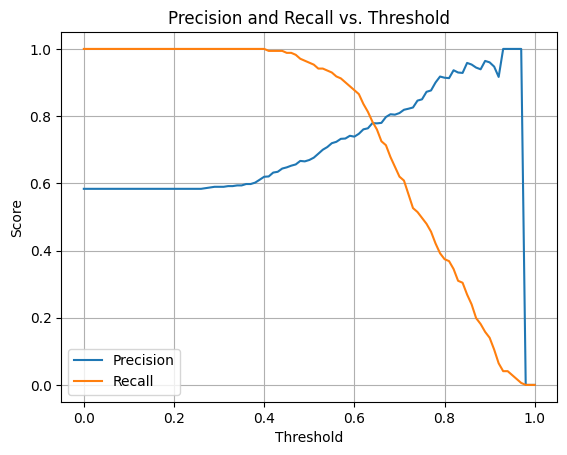

In [26]:
from sklearn.metrics import precision_score, recall_score

import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    y_pred_binary = (y_pred >= t)

    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)

    scores.append((t, precision, recall))

columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

display(df_scores[::10])

# Plot precision and recall
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.grid(True)

> **Answer 3**: They intercept between $0.6$ and $0.8$, the we choise $0.745$

#### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F1 = 2 ⋅ \frac{P ⋅ R}{P + R}$$

Where:

* P is precision and
* R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.14
* 0.34
* 0.54
* 0.74

,threshold,precision,recall,f1
0,0.0,0.583618,1.000000,0.737069
10,0.1,0.583618,1.000000,0.737069
20,0.2,0.583618,1.000000,0.737069
30,0.3,0.589655,1.000000,0.741866
40,0.4,0.619565,1.000000,0.765101
50,0.5,0.669388,0.959064,0.788462
60,0.6,0.738916,0.877193,0.802139
70,0.7,0.809160,0.619883,0.701987
80,0.8,0.914286,0.374269,0.531120
90,0.9,0.960000,0.140351,0.244898


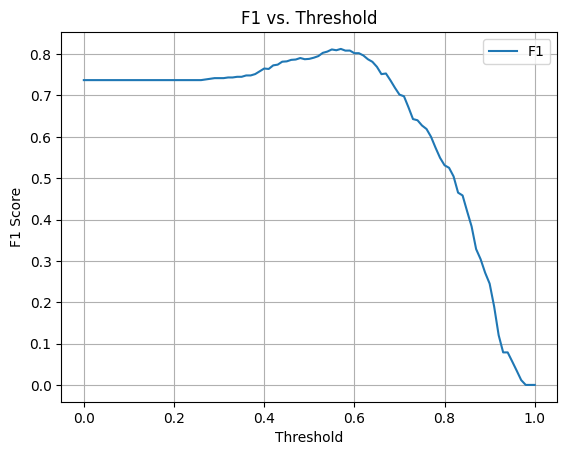

In [33]:
from sklearn.metrics import precision_score, recall_score

import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    y_pred_binary = (y_pred >= t)

    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    if (precision + recall) != 0:
      f1 = 2 * (precision * recall) / (precision + recall)
    else:
      f1 = 0.0

    scores.append((t, precision, recall, f1))

columns = ['threshold', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)

display(df_scores[::10])

# Plot f1
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs. Threshold")
plt.grid(True)

> **Answer 4**: Near by $0.6$

#### Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

* KFold(n_splits=5, shuffle=True, random_state=1)
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

* 0.0001
* 0.006
* 0.06
* 0.36

In [41]:
def train(df, y, features, c):
    cat = df[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    X = dv.transform(cat)
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model, features):
    cat = df[features].to_dict(orient='records')
    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [42]:
from sklearn.model_selection import KFold

aucs = []
kfold = KFold(n_splits=5, shuffle=True, random_state=common_random_state)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    y_train = df_train[target_variable].values

    df_val = df_full_train.iloc[val_idx]
    y_val = df_val[target_variable].values

    dv, model = train(df_train, y_train, all_features, c=1.0)
    y_pred = predict(df_val, dv, model, all_features)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

aucs_rounded = np.array(aucs).round(3)
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.822 ± 0.036


> **Answer #5**: $0.036$ then nearest is: $0.06$

#### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.000001, 0.001, 1]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.000001
* 0.001
* 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [44]:
kfold = KFold(n_splits=5, shuffle=True, random_state=common_random_state)

for c in [0.000001, 0.001, 1]:
  aucs = []
  for train_idx, val_idx in kfold.split(df_full_train):
      df_train = df_full_train.iloc[train_idx]
      y_train = df_train[target_variable].values

      df_val = df_full_train.iloc[val_idx]
      y_val = df_val[target_variable].values

      dv, model = train(df_train, y_train, all_features, c=c)
      y_pred = predict(df_val, dv, model, all_features)

      rocauc = roc_auc_score(y_val, y_pred)
      aucs.append(rocauc)

  aucs_rounded = np.array(aucs).round(3)
  print('c = %0.6f => auc = %0.3f ± %0.3f' % (c, np.mean(aucs), np.std(aucs)))

c = 0.000001 => auc = 0.560 ± 0.024
c = 0.001000 => auc = 0.867 ± 0.029
c = 1.000000 => auc = 0.822 ± 0.036


> **Answer 6**: $c = 0.001000$ => best mean score: $auc = 0.867 ± 0.029$


Submit the results
Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
If your answer doesn't match options exactly, select the closest one